In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import scipy as sp
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("Data/Maternal Health Risk Data Set.csv")
numeric_cols = ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']
df = df[numeric_cols]

scaler = MinMaxScaler()
data = scaler.fit_transform(df)  # Normalizar datos entre 0 y 1
data_dim = data.shape[1]

In [22]:
from scipy.stats import truncnorm

def truncated_gaussian_scipy(mean, std, min_val, max_val, size=1000):
    a, b = (min_val - mean) / std, (max_val - mean) / std  # Normalize bounds
    return truncnorm.rvs(a, b, loc=mean, scale=std, size=size)

In [6]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.BatchNorm1d(16),  # Added BatchNorm
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(16, 64),
            nn.BatchNorm1d(64),  # Added BatchNorm
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 16),
            nn.BatchNorm1d(16),  # Added BatchNorm
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(16, output_dim),
            nn.Sigmoid()  # Ensures output is in [0,1]
        )

    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [7]:
generator = Generator(input_dim=data_dim, output_dim=data_dim)
discriminator = Discriminator(input_dim=data_dim)

criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=1 * 10 ** -4)
optimizer_d = optim.Adam(discriminator.parameters(), lr=1 * 10 ** -4)

In [46]:
def generate_random_data(real_data, batch_size, data_dim, mode="normal_dist"):
    if mode == "normal_dist":
        save_data_list = []
        for i in range(data_dim):
            mean_v = np.mean(real_data_array[:, i])
            std_v = np.std(real_data_array[:, i])
            min_v = np.min(real_data_array[:, i])
            max_v = np.max(real_data_array[:, i])

            col_gen = truncated_gaussian_scipy(mean_v, std_v, min_v, max_v, size=batch_size)
            save_data_list.append(col_gen)
    
        return torch.tensor(np.array(save_data_list).T, dtype=torch.float32)

    elif mode == "random":
        real_data = torch.tensor(data[idx], dtype=torch.float32)
        z = torch.randn(batch_size, data_dim)

        return z
    else:
        print("Error")

In [47]:
num_epochs = 5000
batch_size = 64

save_nn_data_list = []
for epoch in range(num_epochs):
    idx = np.random.randint(0, data.shape[0], batch_size)
    real_data_array = data[idx]
    real_data = torch.tensor(data[idx], dtype=torch.float32)
    
    # Generar datos falsos
    z = generate_random_data(real_data_array, batch_size, data_dim, mode="normal_dist")
    fake_data = generator(z)

    # Entrenar Discriminador
    optimizer_d.zero_grad()
    real_loss = criterion(discriminator(real_data), torch.ones(batch_size, 1))
    fake_loss = criterion(discriminator(fake_data.detach()), torch.zeros(batch_size, 1))
    d_loss = real_loss + fake_loss
    d_loss.backward()
    optimizer_d.step()

    # Entrenar Generador
    optimizer_g.zero_grad()
    g_loss = criterion(discriminator(fake_data), torch.ones(batch_size, 1))
    g_loss.backward()
    optimizer_g.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")

    save_nn_data_list.append({
        "epoch": epoch,
        "discriminator_loss": d_loss.item(),
        "generator_loss": g_loss.item()
    })

df_nn = pd.DataFrame(save_nn_data_list)

Epoch 0, D Loss: 1.2550766468048096, G Loss: 0.8174176812171936
Epoch 500, D Loss: 1.3268342018127441, G Loss: 0.794988751411438
Epoch 1000, D Loss: 1.216282606124878, G Loss: 0.8080809712409973
Epoch 1500, D Loss: 1.2642617225646973, G Loss: 0.8101369142532349
Epoch 2000, D Loss: 1.3811366558074951, G Loss: 0.7749630212783813
Epoch 2500, D Loss: 1.3388371467590332, G Loss: 0.7809141874313354
Epoch 3000, D Loss: 1.3254343271255493, G Loss: 0.7752106785774231
Epoch 3500, D Loss: 1.2840662002563477, G Loss: 0.7776015400886536
Epoch 4000, D Loss: 1.2705457210540771, G Loss: 0.7713971734046936
Epoch 4500, D Loss: 1.3188300132751465, G Loss: 0.7486118674278259


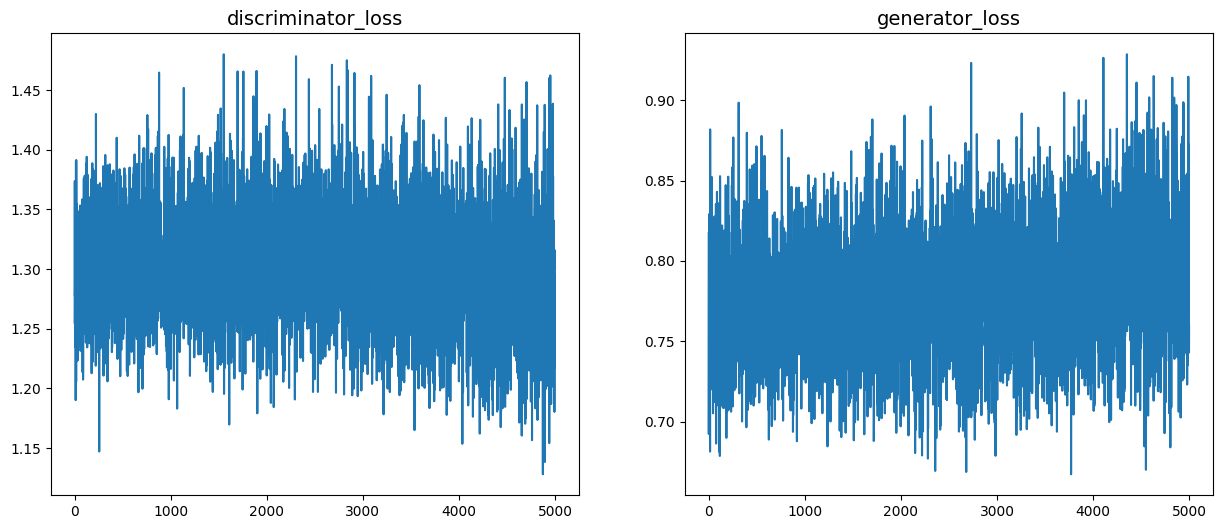

In [48]:
fig = plt.figure(figsize=(15, 6))

fig.add_subplot(1,2,1)
plt.plot(df_nn["epoch"], df_nn["discriminator_loss"])
plt.title("discriminator_loss", fontsize=14)

fig.add_subplot(1,2,2)
plt.plot(df_nn["epoch"], df_nn["generator_loss"])
plt.title("generator_loss", fontsize=14)

plt.show()

In [49]:
z = torch.randn(500, data_dim)  # Generar 5000 nuevas filas
synthetic_data = generator(z).detach().numpy()

# Denormalizar
synthetic_data = scaler.inverse_transform(synthetic_data)

# Guardar en CSV
synthetic_df = pd.DataFrame(synthetic_data, columns=df.columns)
# synthetic_df.to_csv("datos_sinteticos.csv", index=False)

In [50]:
display(synthetic_df)

corr_list = []
for i_c, i_col in enumerate(numeric_cols[:-1]):
    for j_col in numeric_cols[(i_c+1):]:
        corr_v, p_value = sp.stats.pearsonr(synthetic_df[i_col].values, synthetic_df[j_col].values)
        corr_list.append({
            "Feature1": i_col, "Feature2": j_col, "correlation": corr_v, "pvalue": p_value
        })

df_corr = pd.DataFrame(corr_list).sort_values("correlation", ascending=False).reset_index(drop=True)
df_corr

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
0,42.440159,123.368271,81.705177,16.620806,100.522995,43.470562
1,40.317093,117.903763,75.510918,18.581860,100.553665,40.727852
2,30.174719,114.550087,77.197388,12.871845,100.539490,33.314312
3,23.419184,110.955841,81.555374,11.839540,100.596016,36.583389
4,30.245787,114.214577,81.180931,13.134877,100.549843,44.297806
...,...,...,...,...,...,...
495,31.996634,110.291611,75.679077,12.276289,100.564926,41.914509
496,28.549612,84.816231,58.293930,12.728917,102.952003,43.628918
497,21.778376,108.431038,76.997833,11.871587,100.559250,39.174633
498,43.359066,96.219482,65.768486,11.996040,100.566010,40.802547


,Feature1,Feature2,correlation,pvalue
0,SystolicBP,DiastolicBP,0.808547,8.986599e-117
1,Age,BS,0.536537,1.283598e-38
2,Age,SystolicBP,0.477951,6.703011e-30
3,SystolicBP,BS,0.474919,1.710598e-29
4,DiastolicBP,BS,0.434801,1.780111e-24
5,Age,DiastolicBP,0.430268,5.978072e-24
6,BS,HeartRate,0.104479,1.945081e-02
7,BodyTemp,HeartRate,0.021434,6.325568e-01
8,Age,HeartRate,0.007892,8.602769e-01
9,BS,BodyTemp,-0.074513,9.604933e-02


In [51]:
corr_list = []
for i_c, i_col in enumerate(numeric_cols[:-1]):
    for j_col in numeric_cols[(i_c+1):]:
        corr_v, p_value = sp.stats.pearsonr(df[i_col].values, df[j_col].values)
        corr_list.append({
            "Feature1": i_col, "Feature2": j_col, "correlation": corr_v, "pvalue": p_value
        })

df_corr = pd.DataFrame(corr_list).sort_values("correlation", ascending=False).reset_index(drop=True)
df_corr

,Feature1,Feature2,correlation,pvalue
0,SystolicBP,DiastolicBP,0.787006,1.706941e-214
1,Age,BS,0.473284,9.845293e-58
2,SystolicBP,BS,0.425172,8.950869e-46
3,DiastolicBP,BS,0.423824,1.819332e-45
4,Age,SystolicBP,0.416045,1.025503e-43
5,Age,DiastolicBP,0.398026,7.835632e-40
6,BS,HeartRate,0.142867,4.942595e-06
7,BodyTemp,HeartRate,0.098771,1.638156e-03
8,Age,HeartRate,0.079798,1.102373e-02
9,SystolicBP,HeartRate,-0.023108,4.623239e-01


In [52]:
from sdv.metadata import Metadata
from sdv.evaluation.single_table import evaluate_quality

In [53]:
numeric_cols = ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']
metadata = Metadata.detect_from_dataframe(
    data=df[numeric_cols],
    table_name='maternal_metadata'
)

In [54]:
synthetic_df

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
0,42.440159,123.368271,81.705177,16.620806,100.522995,43.470562
1,40.317093,117.903763,75.510918,18.581860,100.553665,40.727852
2,30.174719,114.550087,77.197388,12.871845,100.539490,33.314312
3,23.419184,110.955841,81.555374,11.839540,100.596016,36.583389
4,30.245787,114.214577,81.180931,13.134877,100.549843,44.297806
...,...,...,...,...,...,...
495,31.996634,110.291611,75.679077,12.276289,100.564926,41.914509
496,28.549612,84.816231,58.293930,12.728917,102.952003,43.628918
497,21.778376,108.431038,76.997833,11.871587,100.559250,39.174633
498,43.359066,96.219482,65.768486,11.996040,100.566010,40.802547


In [55]:
quality_report = evaluate_quality(
    df[numeric_cols],
    synthetic_df,
    metadata
)

Generating report ...

(1/2) Evaluating Column Shapes: |███████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 171.93it/s]|
Column Shapes Score: 35.55%

(2/2) Evaluating Column Pair Trends: |████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 130.21it/s]|
Column Pair Trends Score: 97.68%

Overall Score (Average): 66.61%



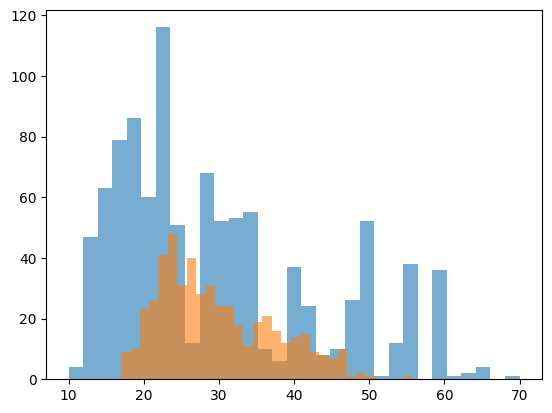

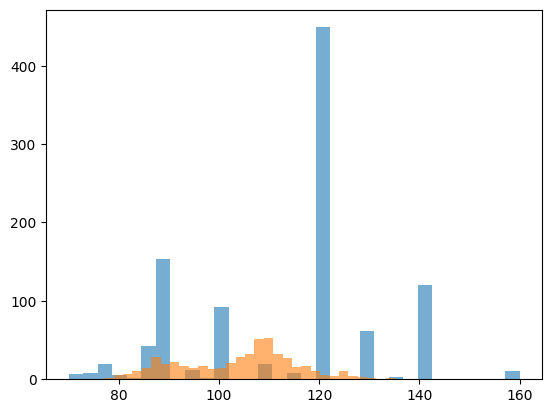

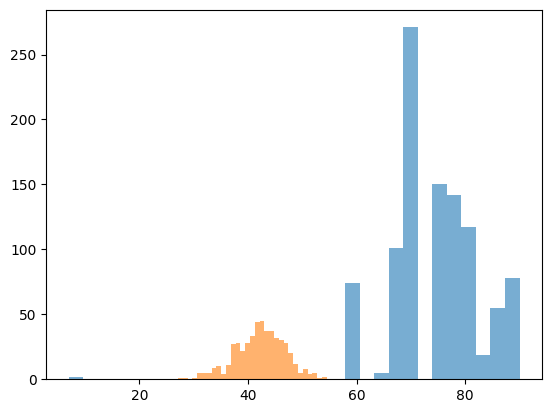

In [57]:
plt.hist(df["Age"].values, bins=31, alpha=0.6)
plt.hist(synthetic_df["Age"].values, bins=31, alpha=0.6)

plt.show()

plt.hist(df["SystolicBP"].values, bins=31, alpha=0.6)
plt.hist(synthetic_df["SystolicBP"].values, bins=31, alpha=0.6)

plt.show()

plt.hist(df["HeartRate"].values, bins=31, alpha=0.6)
plt.hist(synthetic_df["HeartRate"].values, bins=31, alpha=0.6)

plt.show()